In [1]:
import gc
import torch
from typing import List, TypedDict
from pprint import pprint

from pydantic import BaseModel, Field
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_tavily import TavilySearch
from langchain_text_splitters import RecursiveCharacterTextSplitter, HTMLHeaderTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END

In [2]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})
llm_eval = ChatOpenAI(model='gpt-5-nano', temperature=0)
llm_gen = ChatOpenAI(model='gpt-5-mini', temperature=0.1)

def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

In [3]:
urls = [
    "https://google.github.io/styleguide/pyguide.html",
    "https://google.github.io/styleguide/javaguide.html",
    "https://google.github.io/styleguide/jsguide.html"
]

headers_to_split_on = [
    ('h1', 'Header 1'),
    ('h2', 'Header 2'),
    ('h3', 'Header 3')
]
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
html_header_splits = []
for url in urls:
    splits = html_splitter.split_text_from_url(url)
    html_header_splits.extend(splits)

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=50)
doc_splits = text_splitter.split_documents(html_header_splits)

In [4]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name='rag-chroma-2',
    embedding=embeddings
)

retriever = vectorstore.as_retriever()

In [5]:
for chunk in doc_splits[:3]: # 앞부분 3개만 확인
    print(f"Content Preview: {chunk.page_content[:50]}...")
    print(f"Metadata: {chunk.metadata}") 
    print("-" * 20)

Content Preview: AUTHORS:
Prefer only GitHub-flavored Markdown in e...
Metadata: {}
--------------------
Content Preview: Google Python Style Guide...
Metadata: {'Header 1': 'Google Python Style Guide'}
--------------------
Content Preview: Table of Contents  
1 Background  
2 Python Langua...
Metadata: {'Header 1': 'Google Python Style Guide'}
--------------------


In [6]:
class GradeDocuments(BaseModel):
    binary_score: str = Field(description='문서와 질문의 연관성 여부. (yes or no)')

structured_llm_grader = llm_eval.with_structured_output(GradeDocuments)
system = '''
당신은 사용자의 질문에 대해 검색된 문서의 관련성을 평가하는 전문가입니다.
문서에 질문과 관련된 키워드나 의미가 담겨 있으면, 해당 문서를 "관련 있음"으로 평가하세요.
문서가 질문과 관련이 있는지 여부를 "yes" 또는 "no"로 표시해주세요.'''
grade_prompt = ChatPromptTemplate.from_messages(
    [('system', system),
     ('human', '검색된 문서: \n\n {document} \n\n사용자 질문: {question}')]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [7]:
question = '파이썬 코드 작성 가이드'

test = retriever.invoke(question)
test_txt = test[0].page_content
print(retrieval_grader.invoke({'question':question, 'document':test_txt}))

binary_score='yes'


In [8]:
system = '''
당신은 질문에 답변하는 업무를 돕는 도우미입니다.
제공된 문맥을 바탕으로 질문에 답변하세요. 만약 답을 모른다면 모른다고 말하세요.
세 문장을 넘지 않도록 답변을 간결하게 작성하세요.
'''
gen_prompt = ChatPromptTemplate.from_messages(
    [('system', system),
     ('human', '질문: {question} \n문맥: {context} \n답변:')]
)

rag_chain = gen_prompt | llm_gen | StrOutputParser()

In [9]:
generation = rag_chain.invoke(
    {'context':format_docs(doc_splits), 'question':question}
)
print(generation)

요약: Google Python Style Guide를 따르세요 — 코드 자동포맷(예: Black/Pyink), 정적분석(pylint)과 타입체크(pytype)를 사용합니다.  
핵심 규칙: 패키지/모듈 단위로 전체 경로 import, 들여쓰기 4칸, 기본 최대 80자(예외 있음), 함수/모듈/클래스에 적절한 삼중-따옴표 docstring(요약+빈줄+본문), 가변 객체를 기본 인자로 쓰지 말고 리소스는 with로 안전하게 닫고, 예외는 구체적 타입만 처리하며 범용 except는 피합니다.  
네이밍/스타일: 클래스는 CapWords, 함수/변수는 lower_with_under, 상수는 ALL_CAPS, mutable 전역 상태 회피, 가능한 한 짧고 단일 책임의 함수와 명확한 이름 사용(필요시 주석으로 설계 이유 명시).


In [10]:
system = '''
당신은 입력된 질문을 변형하여 웹 검색에 최적화된 형태로 만드는 질문 생성기입니다.
입력된 질문을 보고 그 이면에 있는 의미나 의도를 파악해주세요.
'''
rewrite_prompt = ChatPromptTemplate.from_messages(
    [('system', system),
     ('human', '질문: \n\n {question} \n더 나은 질문으로 바꿔주세요. 단 최적의 질문 하나만 골라서 출력해주세요.')]
)

question_rewriter = rewrite_prompt | llm_gen | StrOutputParser()

In [11]:
question = 'C++ 깔끔하게 짜고 싶다.'
question_rewriter.invoke({'question':question})

'C++로 깔끔하고 유지보수성이 높은 코드를 작성하려면 어떤 모범 사례(코딩 스타일, 모던 C++ 기능 활용, 디자인 패턴, 리팩터링 기법, 정적 분석·포맷터 도구)를 따라야 하나요?'

In [12]:
search_tool = TavilySearch(k=3)

In [13]:
class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [14]:
def retrieve(state):
    print('--- retrieve ---')

    question = state['question']
    documents = retriever.invoke(question)

    return {'question':question, 'documents':documents}

In [15]:
def generate(state):
    print('--- generate ---')

    question = state['question']
    documents = state['documents']

    generation = rag_chain.invoke({'question':question, 'context':documents})

    return {'question':question, 'documents':documents, 'generation':generation}

In [16]:
def grade_documents(state):
    print('--- grade documents ---')

    question = state['question']
    documents = state['documents']

    filtered_docs = []
    web_search = 'no'
    for doc in documents:
        score = retrieval_grader.invoke(
            {'question':question, 'document':doc.page_content}
        )
        grade = score.binary_score
        if grade == 'yes':
            print('-- relavant document --')
            filtered_docs.append(doc)
        else:
            print('-- irrelavant document --')
            web_search = 'yes'
            continue

    return {'question':question, 'document':filtered_docs, 'web_search':web_search}

In [17]:
def transform_query(state):
    print('--- transform query ---')

    question = state['question']
    documents = state['documents']

    better_question = question_rewriter.invoke({'question':question})

    return {'question':question, 'documents':documents}

In [18]:
def web_search(state):
    print('--- web search ---')

    question = state['question']
    documents = state['documents']

    docs = search_tool.invoke({'query':question})
    web_results = Document(page_content='\n'.join(doc['content'] for doc in docs))
    documents.append(web_results)

    return {'question':question, 'documents':documents}

In [19]:
def decide_to_generate(state):
    print('--- decide to generate ---')

    web_search = state['web_search']
    if web_search == 'yes':
        print('there is no relavant document. transform query')
        return 'transform_query'
    else:
        print('there is a relavant document. generate')
        return 'generate'

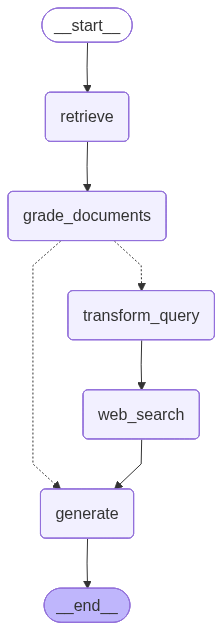

In [20]:
workflow = StateGraph(GraphState)

workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('transform_query', transform_query)
workflow.add_node('web_search', web_search)

workflow.set_entry_point('retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {'transform_query':'transform_query', 'generate':'generate'}
)
workflow.add_edge('transform_query', 'web_search')
workflow.add_edge('web_search', 'generate')
workflow.add_edge('generate', END)

app = workflow.compile()
app

In [21]:
inputs = [{'question':'구글의 코드 작성 가이드'}, {'question':'C++ 깔끔하게 짜고 싶다.'}]
for i in range(len(inputs)):
    for output in app.stream(inputs[i]):
        for key, value in output.items():
            pprint(f'Node "{key}":')
    
    print('---------- 제시 답변 ----------')
    pprint(value['generation'])
    print('---------- 완료 ----------')

--- retrieve ---
'Node "retrieve":'
--- grade documents ---
-- relavant document --
-- relavant document --
-- relavant document --
-- relavant document --
--- decide to generate ---
there is a relavant document. generate
'Node "grade_documents":'
--- generate ---
'Node "generate":'
---------- 제시 답변 ----------
('구글은 언어별 코드 스타일 가이드를 제공하며 예로 JavaScript, Python, Java용 가이드가 있습니다. JavaScript '
 '가이드는 더 이상 업데이트되지 않으며 구글은 TypeScript로 마이그레이션해 TypeScript 가이드를 따를 것을 권장합니다.')
---------- 완료 ----------
--- retrieve ---
'Node "retrieve":'
--- grade documents ---
-- relavant document --
-- relavant document --
-- relavant document --
-- relavant document --
--- decide to generate ---
there is a relavant document. generate
'Node "grade_documents":'
--- generate ---
'Node "generate":'
---------- 제시 답변 ----------
('일관된 포맷과 가독성 중심 규칙(한 줄에 한 문장, 빈 줄로 논리 블록 구분), 작은 함수와 단일 책임 원칙을 지켜 구조를 단순화하세요. '
 '모던 C++ 관행(RAII, 스마트 포인터, const-correctness, 범위 기반 for/auto 등)과 테스트 작성으로 안전성을 '
 '확보하세요. clang-format/clang-tid